# Introduction to Scientific Computation, <br> Project 3 - Industrial Computation
### Dimensionality Reduction and Noise Removal <br> of Face Images with Non-Negative Matrix Factorization

This project uses the 10,000 Cryptopunks images. Download and place in a ./Images folder for the project to work.

Simply put, matrix factorization is to find the two matrices $W$ and $H$, that satisfy $WH = A$. This implies that if $A$ is an $m\times n$ matrix, $W$ and $H$ must respectively be $m\times d$ and $d\times n$ matrices. Here the value $d$ can be chosen as best fit our hearths desire - generally chosen to optimise for a compromise between accuracy and data reduction.

To reduce dimensions of a matrix, Lee and Seung’s multiplicative update rule for NMF will be deployed. A non-negative matrix factorization (NMF) follows the same principle as other matrix factorizations, but restricts all values to be positive. 

Lee and Seung's multiplicative rule for NMF will, provided that all initial values of all three matrices, $A$, $W$, and $H$, are positive, yield non negative matrices $W$ and $H$ as a result. Reasoning through this, from the provided initial conditions, the mean of $A$, and $\sqrt{mean(A)/d}$ must positive scalars. This means that the matrices $W$ and $H$ are scaled by a positive scalar. As all values of $W$ and $H$ already are positive, the matrices stay wholly positive. Hadamard products and divisions of exclusively positive values can only yield positive values, as is true for matrix multiplication. Here both are reflecting the properties of scalar multiplication and division, which are the root operations of these matrix and Hadamard operations. This means that as long as $\delta$ is positive, as is the intention of the value, there will never be introduced any negative values to the matrices. All calulations will therefore exclusively yield positive results for the algorithm, when all initial conditions are positive.


It would be cunterproductive if the algorithm at one iteration arrived at correct values for W and H $(W_kH_k = A)$, but then changed the matrices to less accurate values $(W_{k+1}H_{k+1}\neq A)$. To see that this is not the case, an example will be reasoned through. To show this, it will be demonstrated that $H_k$ is a fixed point $(H_{k+1} = H_k)$, if $W_kH_k=A$. Starting from the algorithms formula for $H_{k+1}$, and the condition that $(W_kH_k = A)$, the following calculation arises:
$$
H_{k+1} 
= H_k \odot (W^T_k A) \oslash (W^T_k W_kH_k) \\
= H_k \odot (W^T_k W_kH_k) \oslash (W^T_k W_kH_k) \\
= H_k \odot \begin{bmatrix} 
1 & \cdots & 1 \\
\vdots & \ddots & \vdots \\
1 & \cdots & 1 \\
\end{bmatrix} \\
= \begin{bmatrix}
h_{11} \cdot 1 & \cdots & h_{1j} \cdot 1 & \cdots & h_{1n} \cdot 1 \\
\vdots         & \ddots & \vdots         &        & \vdots         \\
h_{i1} \cdot 1 & \cdots & h_{ij} \cdot 1 & \cdots & h_{in} \cdot 1 \\
\vdots         &        & \vdots         & \ddots & \vdots         \\
h_{d1} \cdot 1 & \cdots & h_{dj} \cdot 1 & \cdots & h_{dn} \cdot 1 \\ 
\end{bmatrix} \\
= H_k \\
$$
It is apparent that if $(W^T_k A) \oslash (W^T_k W_kH_k)$ is a matrix of only 1's, $H_k$ must be a fixed point. Further, t is apparent that $(W^T_k A) \oslash (W^T_k W_kH_k)$ is indeed equal to a matrix of 1's when $(W_kH_k = A)$. In conclusion it is safe to say that if one iteration k yield two matrices $W_k$ and $H_k$, that are equal to $A$, all subsequent $W$'s and $H$'s will also satisfy $(WH = A)$.

One small additional remark, is that initializing $H_0$ and $W_0$ as matrices filled with zeros, will cause the algorithm to fail. The terms $W^T_k A$ and $AH^T_{k+1}$  would be equal to zero matrices, and neither $H$ nor $W$ would ever contain values unequal to zero.

In [52]:
##### Importing libraries #####
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

In [53]:
##### Implementing Lee and Seung’s multiplicative update rule for NMF   #####
##### It will have uniwue random initializations each time it is calles #####

def NMF_Factorization(A,d,delta=1e-9,max_iter=1000):
    ## Initializing the matrices of shape m X d and d X n, with random values between 0 and 1
    W_0 = np.random.uniform(0,1,(len(A),d))
    H_0 = np.random.uniform(0,1,(d,len(A[0])))

    ## Creating array to store the values of the norms for each iteration, and calculates the initial norm value
    norm_values = np.zeros((max_iter),dtype=np.float64)
    norm_values[0] = np.linalg.norm(A - ( W_0 @ H_0 ), "fro")

    ## Scaling the arrays
    scalar = np.sqrt(np.mean(A)/d)
    W_0 *= scalar
    H_0 *= scalar

    ## Sets the first H_k and W_k equal to H_0 and W_0
    W_k = W_0
    H_k = H_0
    for k in range(1,max_iter):
        ## Calculating H_k+1 and W_k+1
        H_k1 = H_k * (W_k.T @ A) / (W_k.T @ W_k @ H_k + delta)
        W_k1 = W_k * (A @ H_k1.T) / (W_k @ H_k1 @ H_k1.T + delta)

        ## Saving the norm of A - W_{k+1}H_{k+1}, but at k, as k, because it makes for the easiest for loop, is really k+1
        norm_values[k] = np.linalg.norm(A - (W_k1 @ H_k1),"fro")

        ## Setting W_k and H_k to their new values, so all is ready for the next iteration
        H_k = H_k1
        W_k = W_k1


    return W_k, H_k, norm_values

To test and see some of the properties of the Lee and Seung's multiplicative update rule, the following matrices will serve for illustration:
$$
A_1 = \begin{bmatrix}
1&0\\
0&1\\
\end{bmatrix} \quad, \quad A_2 = \begin{bmatrix}
1&2\\
1&1\\
1&2\\
\end{bmatrix} \quad, \quad A_3 = \begin{bmatrix}
2&1&1\\
2&1&1\\
1&1&2\\
\end{bmatrix} \quad, \quad A_4 = \begin{bmatrix}
2&1&0\\
1&2&3\\
0&3&3\\
\end{bmatrix}

$$

In [54]:
##### Defining the matrices A_1 through A_4 in python #####
A_1 = np.identity(2,dtype=float)
A_2 = np.array([[1,2],[1,1],[1,2]])
A_3 = np.array([[2,1,1],[2,1,1],[1,1,2]])
A_4 = np.array([[2,1,0],[1,2,3],[0,3,3]])

In [55]:
##### Defining function for calculating the nmf of a given array, with a given d, and printing W, H, WH, and ||A-WH||_F #####
def calcNmfArrayDPrint(A,d):
    W, H, normValues = NMF_Factorization(A,d)
    WH = W @ H
    print(f"W =\n{W}\nH =\n{H}\nWH =\n{WH}\n||A-WH||_F = {normValues[-1]}\n")

##### Calculating and printing the nmf of A_1 from two different random initializations #####
print("Nmf values for array A_1, with d=1:\nRandom Initialization 1:")
calcNmfArrayDPrint(A_1,1)
print("Random initialization 2:")
calcNmfArrayDPrint(A_1,1)

Nmf values for array A_1, with d=1:
Random Initialization 1:
W =
[[0.68286008]
 [0.52158691]]
H =
[[0.92484505 0.70642155]]
WH =
[[0.63153976 0.48238708]
 [0.48238708 0.36846024]]
||A-WH||_F = 1.0

Random initialization 2:
W =
[[0.10941408]
 [0.19871894]]
H =
[[2.1261694  3.86157019]]
WH =
[[0.23263286 0.42251013]
 [0.42251013 0.76736714]]
||A-WH||_F = 0.9999999999999999



In [56]:
##### Calculating and printing the nmf of A_1 from two different random initializations #####
print("Nmf values for array A_2, with d=1:\nRandom Initialization 1:")
calcNmfArrayDPrint(A_2,1)
print("Random initialization 2:")
calcNmfArrayDPrint(A_2,1)

Nmf values for array A_2, with d=1:
Random Initialization 1:
W =
[[0.70138455]
 [0.42806713]
 [0.70138455]]
H =
[[1.5686759  2.77058029]]
WH =
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]
||A-WH||_F = 0.4111546000651088

Random initialization 2:
W =
[[1.04649255]
 [0.63869251]
 [1.04649255]]
H =
[[1.05136443 1.85690975]]
WH =
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]
||A-WH||_F = 0.4111546000651088



In [57]:
##### Calculating the nmf's of A_1 and A_2 with d=2  #####
print("The nmf of A_1, with d=2:")
calcNmfArrayDPrint(A_1,2)
print("The nmf of A_2, with d=2:")
calcNmfArrayDPrint(A_2,2)

The nmf of A_1, with d=2:
W =
[[0.         0.23088884]
 [0.56302715 0.        ]]
H =
[[0.         1.77611329]
 [4.33108856 0.        ]]
WH =
[[1. 0.]
 [0. 1.]]
||A-WH||_F = 6.085304209601791e-10

The nmf of A_2, with d=2:
W =
[[0.37652957 0.33012837]
 [0.41139068 0.13815963]
 [0.37652957 0.33012837]]
H =
[[2.29105479 0.64218593]
 [0.41605065 5.32580096]]
WH =
[[1. 2.]
 [1. 1.]
 [1. 2.]]
||A-WH||_F = 7.048925453568569e-10



To find the rank of a matrix, all of the matrix's eigenvalues should be found - as each matrix has an eigenvalue for each rank it has (Rank $4\Rightarrow4$ eigenvalues).

In [58]:
##### Finding the rank of the matrices A_3 and A_4 #####

def printRank(name,A):
    eigVal, normalizedEigVec = np.linalg.eig(A)
    rank = len(np.argwhere(np.abs(eigVal)>1e-10))   # Because of how floats are handled, numpy's 'eig' function returns a very small eigenvalue 
                                                    # that should've been zero, thereby jacking up the computers count of the rank.
                                                    # This is solved by a quick fix - excluding the eigenvalues smaller than some quite small value
    print(f"The rank of matrix {name} is {rank}.")

printRank("A_3",A_3)
printRank("A_4",A_4)

The rank of matrix A_3 is 2.
The rank of matrix A_4 is 3.


Now it is time to see if the NMF alorithm makes the reconstruction of $A$, $W_kH_k$, more accurate over time - and if it strictly does so. It is also practical to see how the value of $d$ affect how accurate the matrix factorization is.

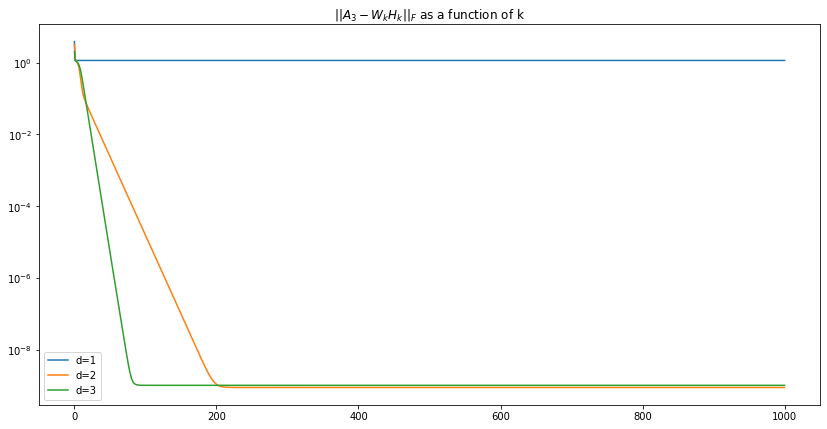

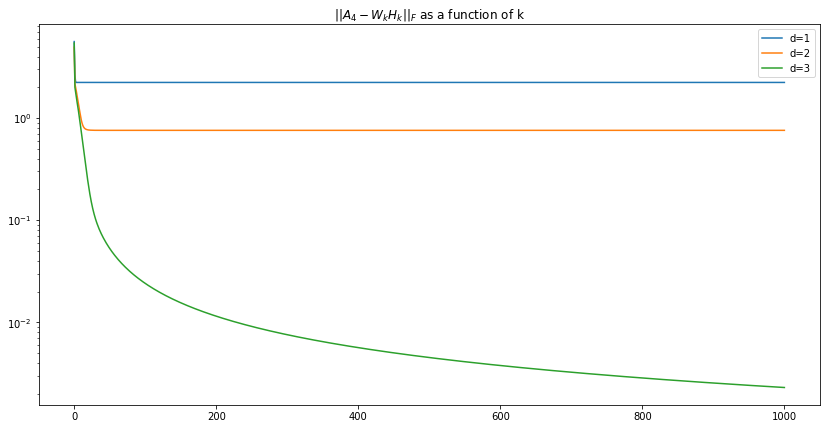

In [59]:
##### Calculating and plotting the norms of A - W_kH_k as a function of iterations, for different d-values #####

def calcnPlot(matrices,mNames,dVals):
    for n in range(len(matrices)):
        plt.figure(figsize=(14,7))
        plt.yscale('log')
        plt.title(f"$|| {mNames[n]} - W_k H_k ||_F $ as a function of k")
        for d in dVals:
            W_k, H_k, normVals = NMF_Factorization(matrices[n],d)
            plt.plot(np.linspace(0,len(normVals),len(normVals)),normVals,label=f"d={d}")
        plt.legend()
        plt.show()

matr = np.array([A_3,A_4])
matrNames = np.array(["A_3","A_4"])
dV = np.array([1,2,3])
calcnPlot(matr,matrNames,dV)
            

From the graphs, it is apparent that the factorization does become better over time, and strictly so. For the matrices it is apparent that $d=Rank(A)$ is the value of $d$ representing the original matrix the closest. For $d< Rank(A)$, the factorization represents the matrix better the greater the value of $d$ is. For $d> Rank(A)$, it seems the factorization is representing the original matrix about as well - it is just more prone to get stuck at local minimums.

Our purpose with NMF factorization is denoising. To do so, some images need first to be loaded. As using all the 10,000 images in the Cryptopunks dataset may be a bit excessive, the provided loading function is extended by a wrapper, which selects a specified number of random images.

In [60]:
##### The pre-written function for loading the images #####
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces


##### Turning the function calls and loading of the provided code into a function, to import images #####
#####  when they are needed, with increased flexibility in regards to the number of random images   #####
def loadNRandomImgs(N):
    # Load all 10000 images
    faces = load_images(10000)

    # Select N random images
    choices = np.random.choice(faces.shape[-1], N, replace = False)
    faces = faces[:,:,:,choices]

    # Check that the shape is correct
    assert faces.shape == (24, 24, 4, N), "The shape of the returned array is wrong"
    return faces
    
randomImageDataSetSubSet = loadNRandomImgs(500)

To have a look at how the dataset generally looks, 64 of the random images will be plotted alongside each other.

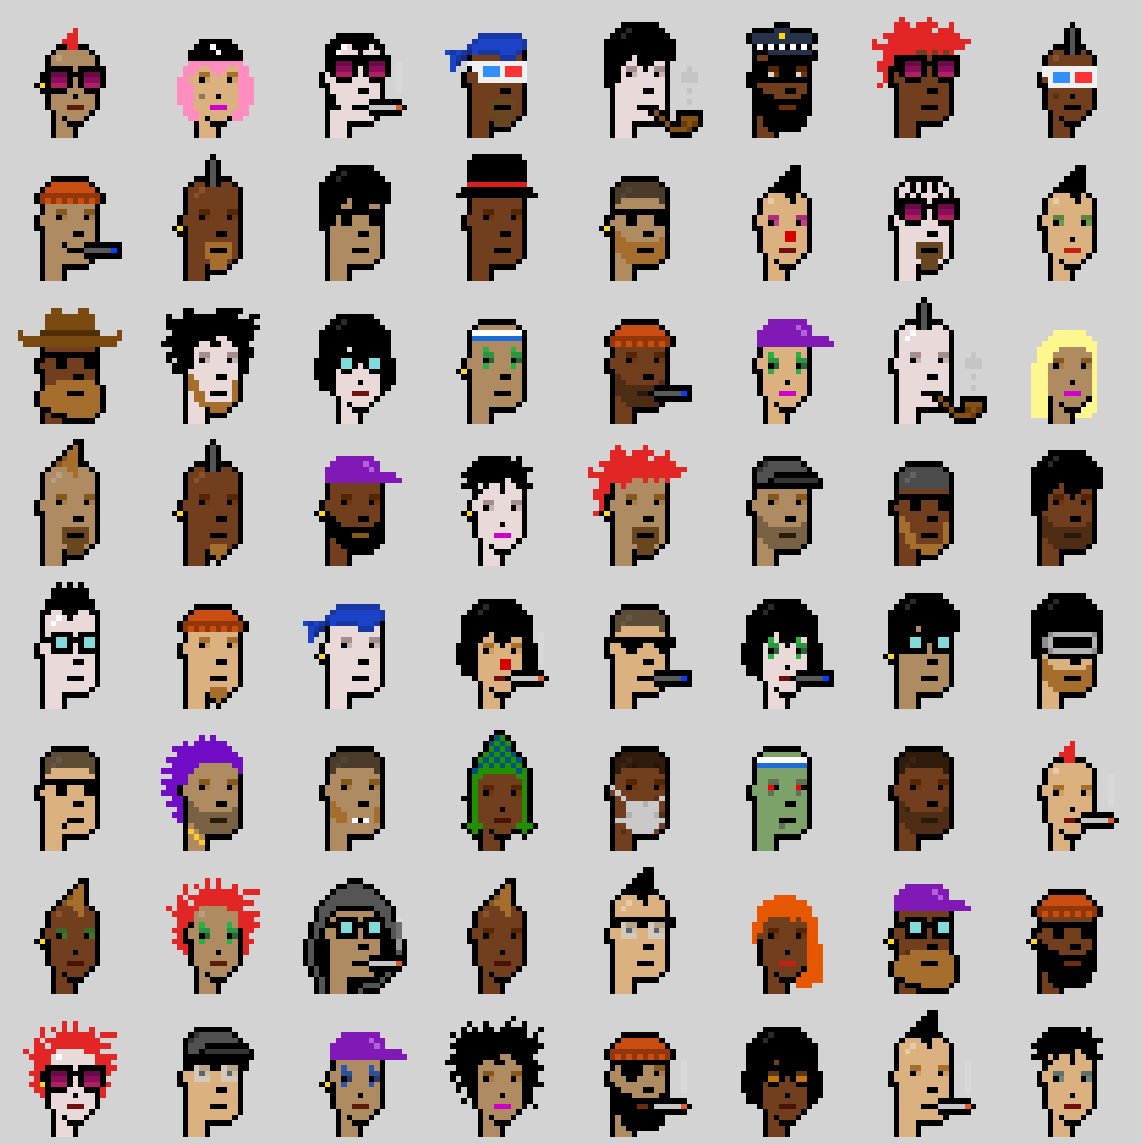

In [61]:
##### The provided code for plotting images #####
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

plotimgs(randomImageDataSetSubSet)

For the matrix factorization to have any chance of reaching a good representation, all of the images should have similar features. To check if this is the case, an average will be calculated and plotted.

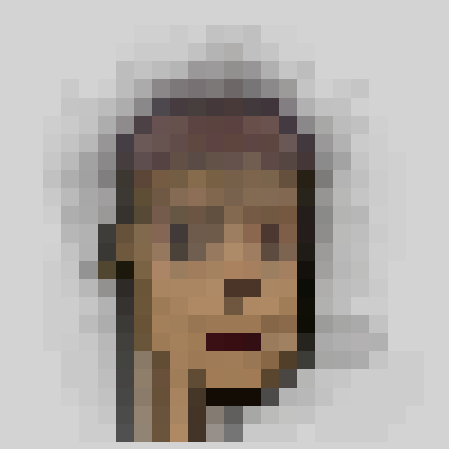

In [67]:
##### Calculating the mean of each of the r, g, and b channels, for each pixel, on the axis along the images, and plotting the resulting mean #####

def plotSingleImage(image):
    oldparams = plt.rcParams['figure.figsize']

    plt.figure(figsize=(8,8))
    plt.gcf().set_facecolor("lightgray")

    plt.axis("off")
    plt.imshow(image)
    plt.show()
    
    plt.rcParams['figure.figsize'] = oldparams
    

plotSingleImage(np.mean(randomImageDataSetSubSet,axis=-1))


As the images seem to have a lot in common, a successful NMF factorization should be possible. To do so, the alpha channel is weeded out to be reintroduced later. Each pixel, and each of its three color channels are rearranged, so that each picture is a simple 1D vector, instead of a $24\times 24\times 3$ array. As there are multiple images, the array of images is now a 2D matrix, which can be factorized by Lee and Seung's rule. Doing so, the following results are obtained.

In [68]:
##### Separating alpha channel from the images, based on the provided code #####
def splitAndConquer(faces):
    # Split the images into opacity and rgb channels
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]

    return faces_rgb, faces_opacity.reshape(24,24,1,500)

##### Reshaping the imagearray to be ready for nmf factorization #####
def nmfReadyArray(images):
    imagesRGB, imagesOpacity = splitAndConquer(images)
    imagesReshaped = imagesRGB.reshape(np.prod(imagesRGB.shape)//len(imagesRGB[0,0,0,:]), len(imagesRGB[0,0,0,:]))
    return imagesReshaped, imagesOpacity

##### NMF factorization of the unreshaped image array #####
def nmfImageArrayFactorization(images,d):
    imagesReshaped, imagesOpacity = nmfReadyArray(images)
    W, H, norms = NMF_Factorization(imagesReshaped,d)
    return W, H, norms, imagesOpacity

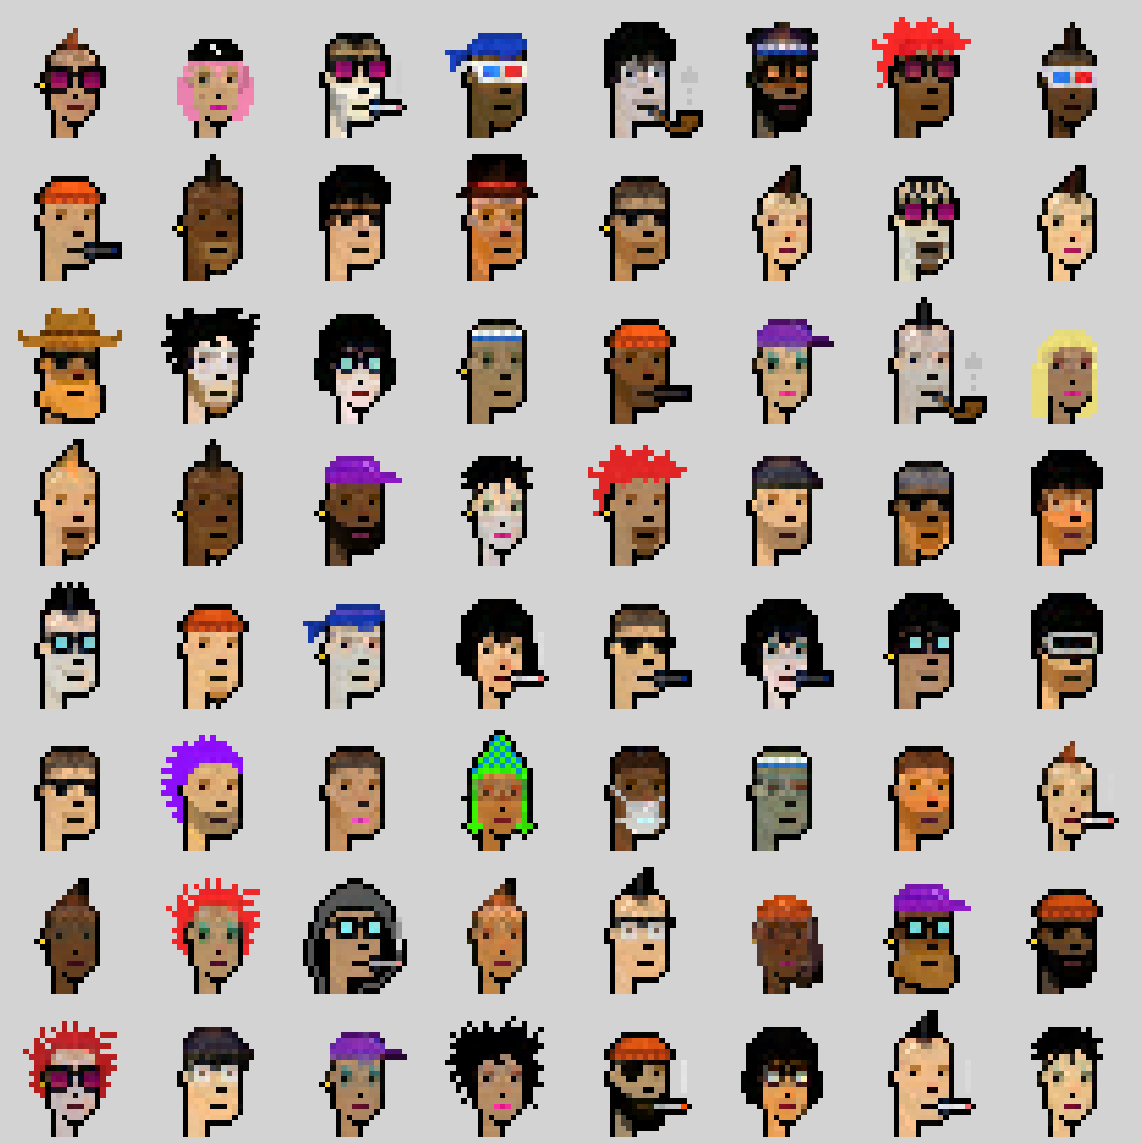

In [69]:
##### NMF factorizing A, reconstructing A from W and H, and plotting the reconstructed images #####
def factorizeReconstructPlot(images,d):
    W, H, norms, imagesOpacity = nmfImageArrayFactorization(images,d)
    reconstructOfA = np.concatenate((np.reshape(W @ H,(24,24,3,500)),imagesOpacity),axis=2) 
    plotimgs(reconstructOfA,8,True)
    
factorizeReconstructPlot(randomImageDataSetSubSet,64)

The factorization reconstructs the images well, altough some of the more unique images are not too well represented. To see how the value of $d$ affects the accuracy of the factorization, the NMF is performed, and the Frobnius norm, of the difference of the representation and A, plotted as a function of the number of iterations. The final norm is also plotted against the value $d$.

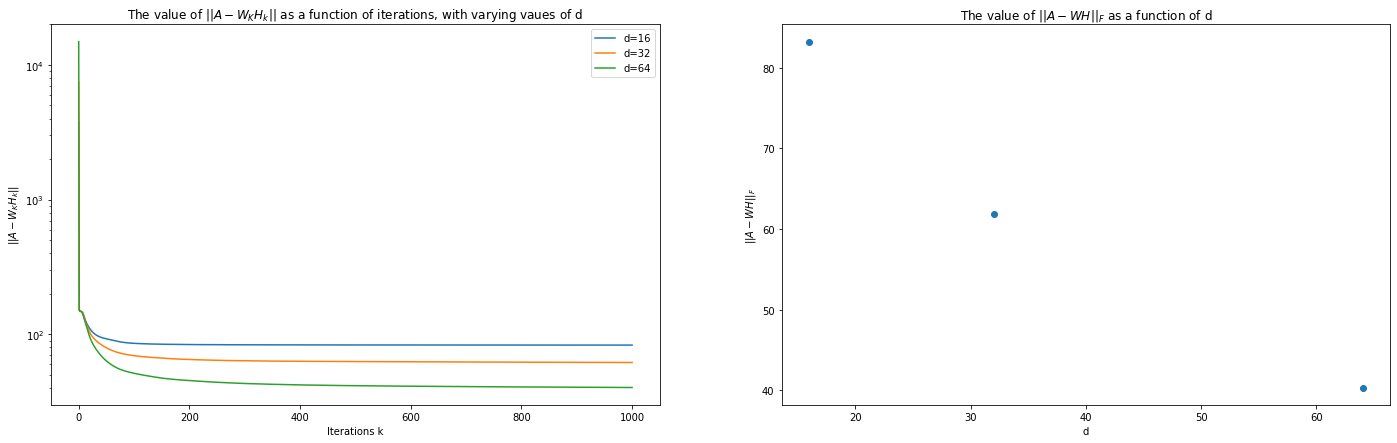

In [75]:
def plotNormForDifferentD(images,dArray):
    plt.figure(figsize=(24,7))
    plt.subplot(1,2,1)
    plt.yscale('log')
    plt.title(f"The value of $||A-W_KH_k||$ as a function of iterations, with varying vaues of d")
    finalNormArray = np.zeros(len(dArray))
    for n in range(len(dArray)):
        W, H, norms, imagesOpacity = nmfImageArrayFactorization(images,dArray[n])
        plt.plot(np.linspace(0,len(norms),len(norms)),norms,label=f"d={dArray[n]}")
        finalNormArray[n] = norms[-1]
    plt.legend()
    plt.xlabel("Iterations k")
    plt.ylabel("$||A-W_KH_k||$")

    plt.subplot(1,2,2)
    plt.title("The value of $||A - WH||_F $ as a function of d")
    plt.xlabel("d")
    plt.ylabel("$||A - WH||_F $")
    plt.scatter(dArray,finalNormArray)
    plt.show()

    return finalNormArray    

finalNormArray = plotNormForDifferentD(randomImageDataSetSubSet,np.array([16,32,64]))

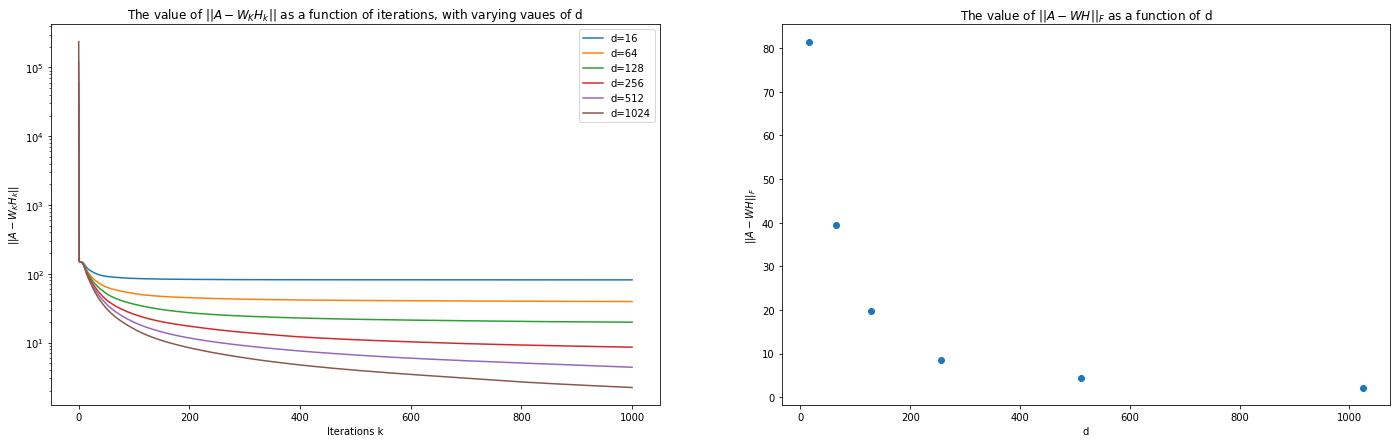

array([81.5337467 , 39.45100061, 19.75426367,  8.5595005 ,  4.37119322,
        2.21854101])

In [76]:
plotNormForDifferentD(randomImageDataSetSubSet,np.array([16,64,128,256,512,1024]))

It is evident that a higher value for $d$ minimises the deviance. However, as previously noted, it increases the data required to store the data, thereby defeating some of the point of the factorization. That the accuracy increases as a function of $d$ makes sense, as the amount of data used to represent the imges increases too.

To use the NMF to denoise the images, it is paramount that the NMF is not too accurate - then the noise would be preserved. By the way NMF's work, they find the average and common features, and smooths out discrepancies. To see this in practice, some noise will be added.

In [72]:
##### Provided code for adding noise to the images #####
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

In [73]:
##### Adding noise to the images, and calculating the Frobenius norm of the difference #####
imagesReshaped, imagesOpacity = nmfReadyArray(randomImageDataSetSubSet)
noisyImageSamples = add_noise(imagesReshaped)
frobNorm = np.linalg.norm((noisyImageSamples - imagesReshaped), "fro")
print(f"||A_Noisy - A||_F = {frobNorm}")

||A_Noisy - A||_F = 41.69070637418088


The noise does change the images quite a bit, as evidenced by the Frobenius norm of the difference between the original images, and the images with added noise. Using NMF the noisy images are factorized, which means they are made more similar to the average of all of the images. To see that this removes noise, the noisy images are plotted below, and beneath that the NMF reconstructions are plotted.

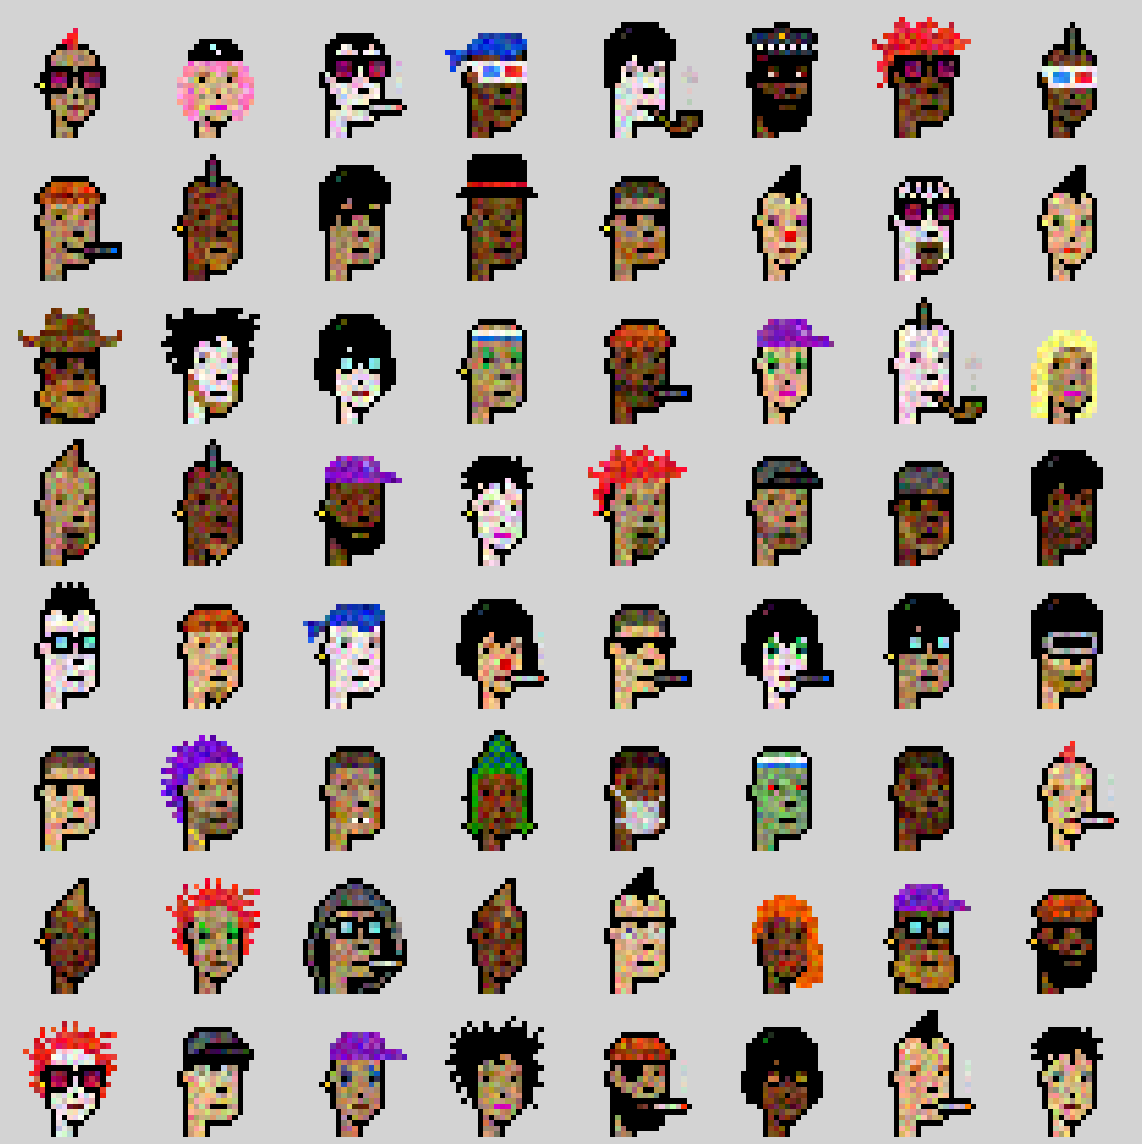

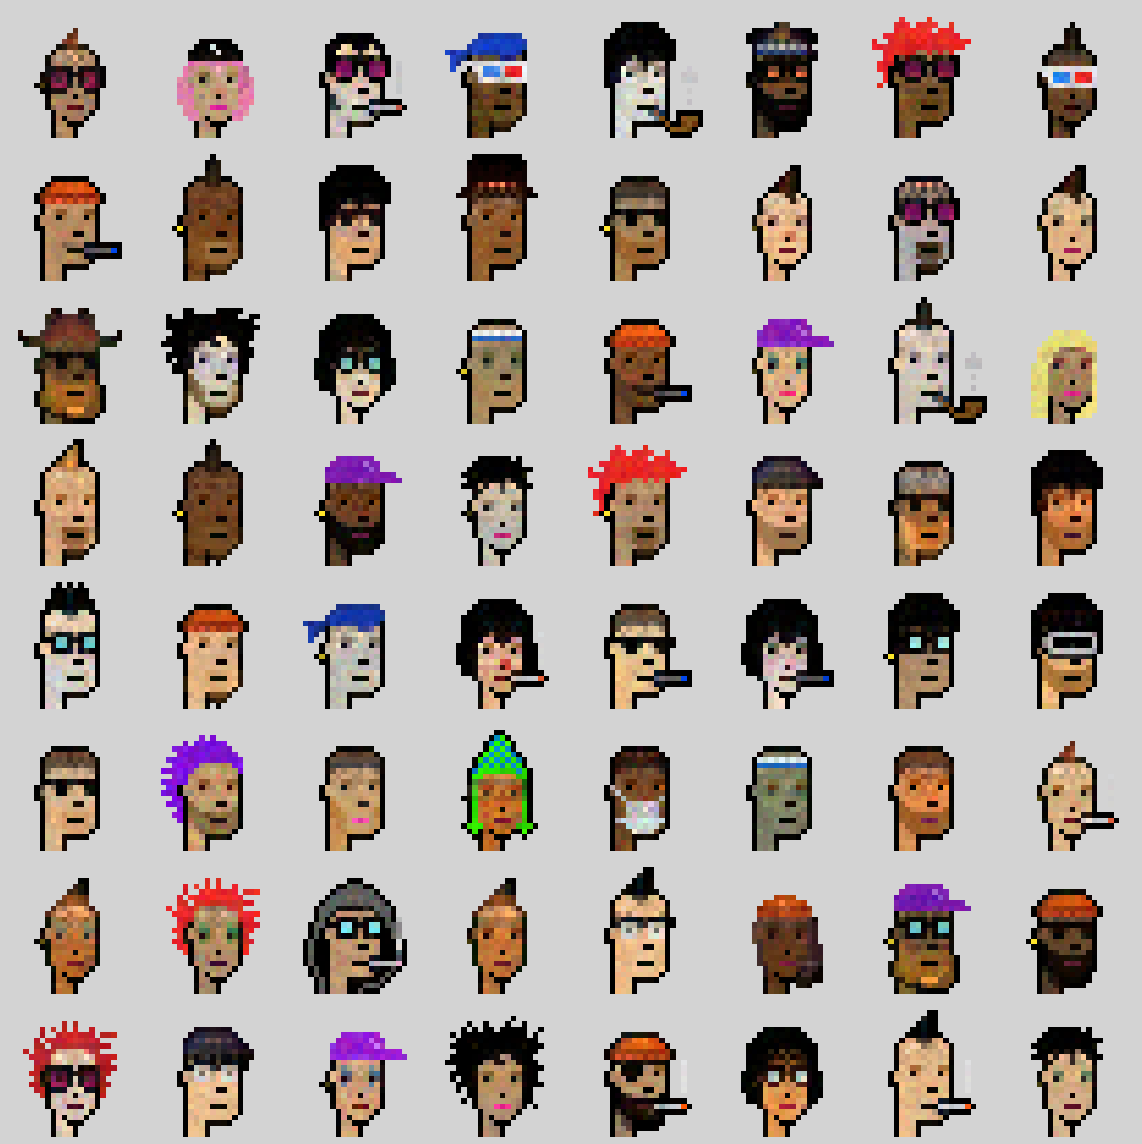

In [74]:
plotimgs(np.concatenate((np.reshape(noisyImageSamples,(24,24,3,500)),imagesOpacity),axis=2))
factorizeReconstructPlot(np.concatenate((np.reshape(noisyImageSamples,(24,24,3,500)),imagesOpacity),axis=2),64)

Looking at the images, it is easy to see that using NMF's can denoise noisy images, but it can also introduce some new problems. Particularly the Zombie loses all of it's original color. This has to do with how the NMF's work - it takes the average. Provided all images are pretty similar, the reconstructions can be very accurate. When the variance is large however, the representations will be worse - particularly for quite unique values, as the Zombie, as the only character of green skin color, is an example of. In conclusion, NMF's are good for compressing and denoising large datasets of quite similar entries, but they may do more damage than good if the dataset is more varied than this one.